In [6]:
from math import sin, cos, pi
from matplotlib import pyplot as plt
import numpy as np

d_to_r = pi/180
LINE = 6 
ANGLE = [0, 9,18,27,36, 45]
SYMMETRY = [(-1, 1), (-1, -1), (1, -1)]

def polar_to_xy(polar):
    coor = []
    for i in range(LINE):
        x = cos(ANGLE[i] * d_to_r) * polar[i]
        y = sin(ANGLE[i] * d_to_r) * polar[i]
        coor.append([x, y])
    for i in range(LINE-1, -1, -1):
        coor.append([coor[i][1], coor[i][0]])
    quarter = 1
    for dx, dy in SYMMETRY:
        if quarter%2 == 1:
            for i in range(LINE*2 - 1, -1, -1):
                coor.append([coor[i][0]*dx, coor[i][1]*dy])
        else:
            for i in range(LINE*2):
                coor.append([coor[i][0]*dx, coor[i][1]*dy])
        quarter += 1 
    return coor

def spectrum_generator(shape):
    vertices = [mp.Vector3(shape[0][0], shape[0][1])] 
    for i in range(1, len(shape) - 1):
        # eliminate duplicate point
        if abs(shape[i][0] - shape[i-1][0]) < 1e-5 and abs(shape[i][1] - shape[i-1][1]) < 1e-5:
            continue
        vertices.append(mp.Vector3(shape[i][0], shape[i][1]))
        print(shape[i])
    # calculate transmission
    return get_trans(vertices)
    

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import math
import meep as mp
import cmath

shape_size = 48

sx, sy, sz = 1, 1, 4
h = 1.25
dpml = 0.5
b_m, c_m = 1.4, 3.54
res = 15
echo = 1000
cell_size = mp.Vector3(sx,sy,sz)
fcen = 0.5
df = 0.2
theta = math.radians(0)
nfreq = 200

# k with correct length (plane of incidence: XZ) 
k = mp.Vector3(math.sin(theta),0,math.cos(theta)).scale(fcen)
def pw_amp(k, x0):
    def _pw_amp(x):
        return cmath.exp(1j * 2 * math.pi * k.dot(x + x0))
    return _pw_amp

def get_trans(vertices):
    geometry = [mp.Block(size = cell_size, material=mp.Medium(index=b_m)),
                mp.Prism(vertices, 
                         height=h, 
                         material=mp.Medium(index=c_m),
                         center=mp.Vector3()
                        )]
    pml_layers = [mp.PML(thickness=1, direction = mp.Z, side=mp.High),
                  mp.Absorber(thickness=1,direction = mp.Z, side=mp.Low)]
    src_pos = -(sz/2 - dpml - 0.5)
    src = [mp.Source(src = mp.GaussianSource(fcen, fwidth=df),
                     component = mp.Ey,
                     center = mp.Vector3(0,0,src_pos),
                     size = mp.Vector3(sx,sy,0),
                     amp_func=pw_amp(k,mp.Vector3(0,0,src_pos)))]
    sim = mp.Simulation(resolution=res,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=src,
                        geometry=geometry,
                        k_point=k)
    freg = mp.FluxRegion(center=mp.Vector3(0,0,-src_pos),
                         size = mp.Vector3(sx,sy,0))
    trans = sim.add_flux(fcen, df, nfreq, freg)
    sim.run(until = echo)
    bend = mp.get_fluxes(trans)
    
    #get straight
    sim.reset_meep()
    geometry = [mp.Block(size = cell_size, material=mp.Medium(index=b_m))]
    pml_layers = [mp.PML(thickness= 1, direction = mp.Z, side=mp.High),
                  mp.Absorber(thickness=1,direction = mp.Z, side=mp.Low)]
    src = [mp.Source(src = mp.GaussianSource(fcen, fwidth=df),
                     component = mp.Ey,
                     center = mp.Vector3(0,0,src_pos),
                     size = mp.Vector3(sx,sy,0),
                     amp_func=pw_amp(k,mp.Vector3(0,0,src_pos)))]
    sim = mp.Simulation(resolution=res,
                        cell_size=cell_size,
                        boundary_layers=pml_layers,
                        sources=src,
                        geometry=geometry,
                        k_point=k)
    freg = mp.FluxRegion(center=mp.Vector3(0,0,-src_pos),
                         size = mp.Vector3(sx,sy,0))
    trans = sim.add_flux(fcen, df, nfreq, freg)
    sim.run(until = echo)
    straight = mp.get_fluxes(trans)
    flux_freqs = mp.get_flux_freqs(trans)
    sim.reset_meep()
    c = 300
    p = 0.6
    Ts = []
    for i in range(nfreq):
        Ts = np.append(Ts, bend[i]/straight[i])
    return np.multiply(flux_freqs, c/p),Ts


In [17]:
T_shape = [0.2,        0.2,        0.1815962,  0.17013016, 0.1638203,  0.1618034        ]
P_shape = [0.17181343, 0.17016014, 0.17800355, 0.1811893,  0.18654697, 0.19009496]

In [18]:
freq, Ts = spectrum_generator(polar_to_xy(P_shape))

[0.16806518631203632, 0.026618910472070788]
[0.16929143615117018, 0.05500612200907067]
[0.16144084841312345, 0.08225822085445866]
[0.1509196689791535, 0.10964955782584643]
[0.13441743528538552, 0.1344174352853855]
[0.10964955782584643, 0.1509196689791535]
[0.08225822085445866, 0.16144084841312345]
[0.05500612200907067, 0.16929143615117018]
[0.026618910472070788, 0.16806518631203632]
[0.0, 0.17181343]
[-0.026618910472070788, 0.16806518631203632]
[-0.05500612200907067, 0.16929143615117018]
[-0.08225822085445866, 0.16144084841312345]
[-0.10964955782584643, 0.1509196689791535]
[-0.1344174352853855, 0.13441743528538552]
[-0.1509196689791535, 0.10964955782584643]
[-0.16144084841312345, 0.08225822085445866]
[-0.16929143615117018, 0.05500612200907067]
[-0.16806518631203632, 0.026618910472070788]
[-0.17181343, 0.0]
[-0.16806518631203632, -0.026618910472070788]
[-0.16929143615117018, -0.05500612200907067]
[-0.16144084841312345, -0.08225822085445866]
[-0.1509196689791535, -0.10964955782584643]
[-

Meep progress: 591.4/1000.0 = 59.1% done in 144.2s, 99.6s to go
Meep progress: 600.8666666666667/1000.0 = 60.1% done in 148.2s, 98.4s to go
Meep progress: 611.0666666666666/1000.0 = 61.1% done in 152.2s, 96.9s to go
Meep progress: 628.0333333333333/1000.0 = 62.8% done in 156.2s, 92.5s to go
Meep progress: 647.9/1000.0 = 64.8% done in 160.2s, 87.1s to go
Meep progress: 667.8/1000.0 = 66.8% done in 164.2s, 81.7s to go
Meep progress: 687.3/1000.0 = 68.7% done in 168.2s, 76.5s to go
Meep progress: 706.7666666666667/1000.0 = 70.7% done in 172.2s, 71.4s to go
Meep progress: 723.5666666666666/1000.0 = 72.4% done in 176.2s, 67.3s to go
Meep progress: 740.0666666666666/1000.0 = 74.0% done in 180.2s, 63.3s to go
Meep progress: 756.9333333333333/1000.0 = 75.7% done in 184.2s, 59.2s to go
Meep progress: 773.9333333333333/1000.0 = 77.4% done in 188.2s, 55.0s to go
Meep progress: 791.7/1000.0 = 79.2% done in 192.2s, 50.6s to go
Meep progress: 810.0/1000.0 = 81.0% done in 196.2s, 46.0s to go
Meep pro

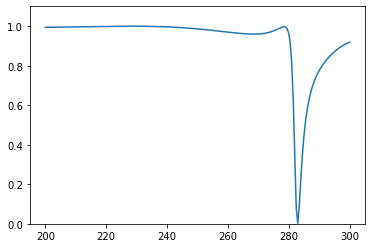

In [19]:
plt.ylim(0, 1.1)
plt.plot(freq, Ts)
plt.show()

T_shape = [0.2,        0.2,        0.1815962,  0.17013016, 0.1638203,  0.1618034        ]<br>
P_shape = [0.17181343, 0.17016014, 0.17800355, 0.1811893,  0.18654697, 0.19009496]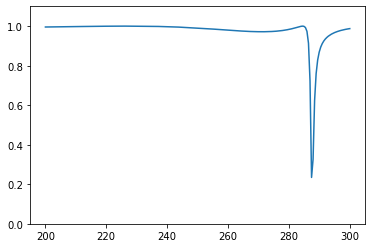

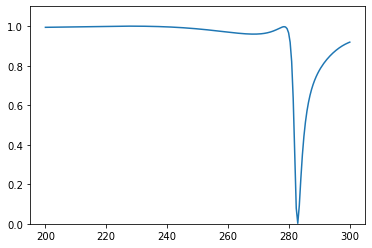

T_shape = [0.1,        0.13169178, 0.2,        0.19507534, 0.19507534, 0.2        ]<br>
P_shape = [0.16922429, 0.16843325, 0.17408204, 0.17719942, 0.1803952,  0.17700543]
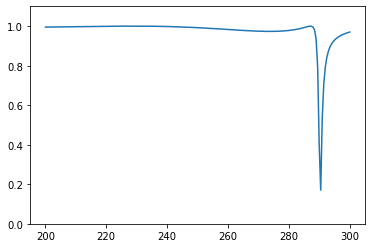

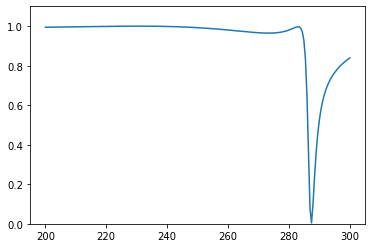

T_shape = [0.1,        0.13169178, 0.2,        0.2,        0.19258231, 0.1902113       ]<br>
P_shape = [0.1716361,  0.17043129, 0.17717591, 0.18033218, 0.18460575, 0.18469079]
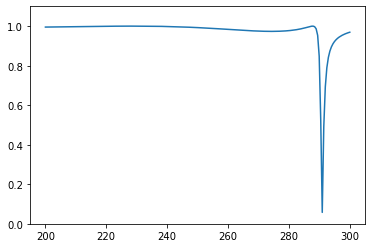

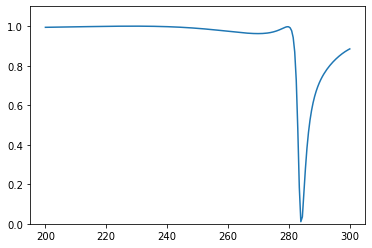

T_shape = [0.1902113,  0.19258231, 0.2,        0.2,        0.19753767, 0.2       ]<br>
P_shape = [0.18850169, 0.18643472, 0.19625267, 0.19935116, 0.20691542, 0.21789409]
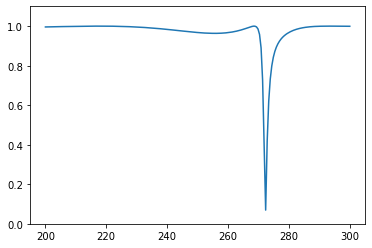

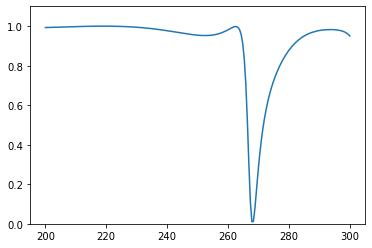